In [1]:
#Libs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
#data
dim_cd_df = pd.read_csv('../data/interim_data/dim_cd_df.csv',index_col=0)
dim_qq_df = pd.read_csv('../data/interim_data/dim_qq_df.csv',index_col=0)
FACT_df = pd.read_csv('../data/interim_data/FACT_df.csv',index_col=0)

In [3]:
#Subset the Fact table for only data from the US for 2020 and remove rows where the answer was NA
us_data = pd.merge(FACT_df,dim_cd_df[['Account_Num','Country','geometry']],on='Account_Num')
us_data.drop_duplicates(inplace=True)
us_data=us_data.query("Country == 'United States of America' & Year ==2020 & Answer != 'Question not applicable'")
us_data.head()
us_data.shape

(78718, 6)

In [4]:
#merge with dim_qq_df for the question section
us_data = pd.merge(us_data,dim_qq_df[['Question_ID','Sect']],on='Question_ID')
us_data.shape

(78718, 7)

In [5]:
#sample 5000 rows
us_data_sample = us_data.sample(5000).reset_index(drop=True)
us_data_sample.shape

(5000, 7)

In [6]:
#Text Encoding the FACT table's answers columns with spaCy
#!pip install spaCy           --install packages
#!python -m spacy download en_core_web_md    #--download english model

In [8]:
import spacy
nlp = spacy.load("en_core_web_md")

## Generate a corpus of answers

In [12]:
docs = list(nlp.pipe(us_data_sample.Answer))

In [13]:
def extract_tokens_plus_meta(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (i.text, i.i, i.lemma_.lower(), i.ent_type_, i.tag_, 
         i.dep_, i.pos_, i.is_stop, i.is_alpha, 
         i.is_digit, i.is_punct) for i in doc
    ]

In [14]:
def tidy_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct"
    ]
    
    meta_df = []
    for ix, doc in enumerate(docs):
        meta = extract_tokens_plus_meta(doc)
        meta = pd.DataFrame(meta)
        meta.columns = cols[1:]
        meta = meta.assign(doc_id = ix).loc[:, cols]
        meta_df.append(meta)
        
    return pd.concat(meta_df).reset_index(drop=True)

In [15]:
#create a new table of our answers broken down by spaCy attributes
tidy_doc = tidy_tokens(docs)

In [16]:
tidy_doc.head()

,doc_id,token,token_order,lemma,ent_type,tag,dep,pos,is_stop,is_alpha,is_digit,is_punct
0,0,Yes,0,yes,,UH,ROOT,INTJ,False,True,False,False
1,1,Improved,0,improve,,VBN,amod,VERB,False,True,False,False
2,1,access,1,access,,NN,ROOT,NOUN,False,True,False,False
3,1,to,2,to,,IN,prep,ADP,True,True,False,False
4,1,data,3,datum,,NNS,pobj,NOUN,False,True,False,False


In [17]:
#Add an index to our US data
us_data_sample=us_data_sample.reset_index()

In [19]:
us_data_sample.head()

,index,Account_Num,Year,Question_ID,Answer,Country,geometry,Sect
0,0,55419,2020,2547,Yes,United States of America,POINT (-80.3036 25.9861),Food
1,1,35870,2020,8040,Improved access to data for informed decision-...,United States of America,POINT (-80.1918 25.7617),Adaptation Actions
2,2,63999,2020,5470,Yes,United States of America,POINT (-80.13 25.7906),Climate Hazards
3,3,53921,2020,8691,110000,United States of America,POINT (-111.94 33.4255),Adaptation Actions
4,4,73301,2020,5365,Flood and sea level rise > Permanent inundation,United States of America,POINT (-90.0542 29.9164),Climate Hazards


In [20]:
#merge to add question id and geometry
df_merge = pd.merge(tidy_doc,us_data_sample[['index','Sect','geometry']], 
                    left_on ='doc_id',right_on='index')
#drop the duplicate column 
df_merge.drop(columns='index',inplace=True)

#reorder
df_merge=df_merge[['Sect','doc_id','geometry',
                   'token','token_order','lemma',
                   'ent_type','tag','dep',
                   'pos','is_stop','is_alpha',
                   'is_digit','is_punct']]

In [21]:
#Now we can sort by Question ID
df_merge.sort_values(['Sect','doc_id','token_order']).head()

,Sect,doc_id,geometry,token,token_order,lemma,ent_type,tag,dep,pos,is_stop,is_alpha,is_digit,is_punct
1,Adaptation Actions,1,POINT (-80.1918 25.7617),Improved,0,improve,,VBN,amod,VERB,False,True,False,False
2,Adaptation Actions,1,POINT (-80.1918 25.7617),access,1,access,,NN,ROOT,NOUN,False,True,False,False
3,Adaptation Actions,1,POINT (-80.1918 25.7617),to,2,to,,IN,prep,ADP,True,True,False,False
4,Adaptation Actions,1,POINT (-80.1918 25.7617),data,3,datum,,NNS,pobj,NOUN,False,True,False,False
5,Adaptation Actions,1,POINT (-80.1918 25.7617),for,4,for,,IN,prep,ADP,True,True,False,False


#### Lets investigate those blank spaces

In [23]:
#lets investigate those blanks-a.k.a the POS of SPACE
#this will take the spaces and place the "prevous and next tokens" around the space. 
(df_merge
 .groupby("doc_id")
 .apply(lambda x: x.assign(
     prev_token = lambda x: x.token.shift(1), 
     next_token = lambda x: x.token.shift(-1))
       )
 .reset_index(drop=True)
 .query("pos == 'SPACE'")
 .loc[:, ["doc_id", "prev_token", "token", "next_token"]]
).head()

,doc_id,prev_token,token,next_token
141,22,.,,Town
164,22,Panel,,on
185,22,.,,The
1042,84,.,,The
1679,125,.,,Existing


In [854]:
#pull out an example text. You can see the extra space between "traveled,  and transition"
list(us_data_sample.loc[us_data_sample.index==223].Answer)

['Pittsburgh Greenhouse gas emission reduction goals (Based on a 2003 Baseline)Citywide - 20% GHG Reduction by 2023- 50% GHG Reduction by 2030- 80% GHG Reduction by 2050In order to reach the boarder goals identified above our Climate Action Plan outlines strategies to  address transportation through the creation of rapid transit and complete streets, transition City owned fleets to renewables or cleaner fuel sources, locate a site for waste transfer station to reduce vehicle miles traveled,  transition water filtration and sanitation plants to cleaner fuels, address transmission of water to reduce losses, address use and transmission of energy through the instillation of renewable energy and CHP, and engaging with businesses and homeowners to increase the operational efficiency of their privately properties.  All of which is outlined in greater detail in our Climate Action and Resilience plans.']

We can see from investigating doc number 223, the space is just a typo error of an additional space

In [24]:
#remove punctuation and stop words
#later analysis shows that POS of "SPACE" made it into the analysis. I'll remove those as well
df_merge_simplified=df_merge.query("is_stop == False & is_punct == False & pos != 'SPACE'")
df_merge_simplified

,Sect,doc_id,geometry,token,token_order,lemma,ent_type,tag,dep,pos,is_stop,is_alpha,is_digit,is_punct
0,Food,0,POINT (-80.3036 25.9861),Yes,0,yes,,UH,ROOT,INTJ,False,True,False,False
1,Adaptation Actions,1,POINT (-80.1918 25.7617),Improved,0,improve,,VBN,amod,VERB,False,True,False,False
2,Adaptation Actions,1,POINT (-80.1918 25.7617),access,1,access,,NN,ROOT,NOUN,False,True,False,False
4,Adaptation Actions,1,POINT (-80.1918 25.7617),data,3,datum,,NNS,pobj,NOUN,False,True,False,False
6,Adaptation Actions,1,POINT (-80.1918 25.7617),informed,5,informed,,JJ,amod,ADJ,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56196,Water Supply Management,4998,POINT (-149.9 61.2181),wells,11,well,,NNS,pobj,NOUN,False,True,False,False
56198,Water Supply Management,4998,POINT (-149.9 61.2181),diversify,13,diversify,,VB,advcl,VERB,False,True,False,False
56200,Water Supply Management,4998,POINT (-149.9 61.2181),water,15,water,,NN,compound,NOUN,False,True,False,False
56201,Water Supply Management,4998,POINT (-149.9 61.2181),supply,16,supply,,NN,dobj,NOUN,False,True,False,False


In [933]:
df_merge_simplified.query("pos=='NUM' &Sect =='Transport'")

,Sect,doc_id,geometry,token,token_order,lemma,ent_type,tag,dep,pos,is_stop,is_alpha,is_digit,is_punct
68,Transport,25,POINT (-77.0369 38.9072),1.6,0,1.6,CARDINAL,CD,ROOT,NUM,False,False,False,False
577,Transport,51,POINT (-106.374 39.6403),64,0,64,CARDINAL,CD,ROOT,NUM,False,False,True,False
798,Transport,79,POINT (-91.5302 41.6611),0,0,0,CARDINAL,CD,ROOT,NUM,False,False,True,False
1108,Transport,123,POINT (-87.6298 41.8781),405,0,405,CARDINAL,CD,ROOT,NUM,False,False,True,False
1400,Transport,134,POINT (-71.2269 42.4443),1100,0,1100,CARDINAL,CD,ROOT,NUM,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53422,Transport,4824,POINT (-122.419 37.7749),691,0,691,CARDINAL,CD,ROOT,NUM,False,False,True,False
53572,Transport,4832,POINT (-97.7431 30.2672),2018,0,2018,DATE,CD,ROOT,NUM,False,False,True,False
54233,Transport,4959,POINT (-104.985 39.7376),0,0,0,CARDINAL,CD,ROOT,NUM,False,False,True,False
54380,Transport,4984,POINT (-97.7431 30.2672),100,0,100,CARDINAL,CD,ROOT,NUM,False,False,True,False


## Text Exploration

1. Lets find the average number of words per sector
2. Find the number of those words that exist in each doc_id (which is a unique combo of respondee and question)

In [25]:
#How many unique sectors are there?
len(df_merge_simplified.Sect.unique())

33

In [29]:
#unique lemma per sector
unique_lemma = df_merge_simplified.groupby('Sect')['lemma'].nunique().sort_values(ascending=False)
unique_lemma.head(10)

Sect
Mitigation Actions              1376
Climate Hazards                 1263
Adaptation Actions              1175
Opportunities                    752
Governance                       711
Mitigation Planning              653
City-wide GHG Emissions Data     650
Water Supply Management          640
Introduction                     589
Energy                           526
Name: lemma, dtype: int64

In [30]:
#number of different doc_id per group
unique_doc_id = df_merge_simplified.groupby('Sect')['doc_id'].nunique().sort_values(ascending=False)
unique_doc_id.head(10)

Sect
Climate Hazards                              1024
Mitigation Actions                            622
Adaptation Actions                            612
City-wide GHG Emissions Data                  487
Energy                                        231
GCoM Emission Factor and Activity Data        215
Climate Risk and Vulnerability Assessment     177
Transport                                     157
Adaptation Planning                           141
Mitigation Target setting                     139
Name: doc_id, dtype: int64

Intersting to see the few responses for sectors such as urban planning, data management, and adaptation planning processes. We will subset these values for sectors with more than 20 responses

In [31]:
unique_doc_id = unique_doc_id.loc[unique_doc_id.values > 20].sort_values(ascending=False)
unique_doc_id.head(10)

Sect
Climate Hazards                              1024
Mitigation Actions                            622
Adaptation Actions                            612
City-wide GHG Emissions Data                  487
Energy                                        231
GCoM Emission Factor and Activity Data        215
Climate Risk and Vulnerability Assessment     177
Transport                                     157
Adaptation Planning                           141
Mitigation Target setting                     139
Name: doc_id, dtype: int64

In [33]:
#The average number of unique Lemma per answer
words_per_id = unique_lemma/unique_doc_id
words_per_id = (words_per_id.loc[words_per_id.notnull()].sort_values(ascending=False)).astype('int')
words_per_id.head(10)

Sect
Food                                  12
Governance                            11
Opportunities                         10
Collaboration                          7
Water Supply Management                6
Mitigation Planning                    5
Waste                                  4
Finance and Economic Opportunities     4
City-wide external verification        4
Water Supply                           3
dtype: int64

In [34]:
#subset our data to important features
data_sect_id_pos_lemma =df_merge_simplified[['Sect','doc_id','pos','lemma']]\
                        .sort_values(['Sect','doc_id','pos'])
data_sect_id_pos_lemma

,Sect,doc_id,pos,lemma
6,Adaptation Actions,1,ADJ,informed
2,Adaptation Actions,1,NOUN,access
4,Adaptation Actions,1,NOUN,datum
7,Adaptation Actions,1,NOUN,decision
9,Adaptation Actions,1,NOUN,making
...,...,...,...,...
56185,Water Supply Management,4998,PROPN,anchorage
56186,Water Supply Management,4998,PROPN,water
56188,Water Supply Management,4998,PROPN,wastewater
56191,Water Supply Management,4998,VERB,search


In [35]:
#Count of words per sector. Lets remove those with less than 30 words

#subset the table above for section and lemma
lemma_counts =data_sect_id_pos_lemma[['Sect','lemma']]

#group by Sect, count # of lemma, and sort values 
lemma_counts_grouped = lemma_counts.groupby('Sect',as_index=False)\
                        .lemma.count()\
                        .sort_values('lemma',ascending=False)

#create a list of counts above 30. Anything less won't be great for analysis
sects_over_30 = list(lemma_counts_grouped.loc[lemma_counts_grouped.lemma > 30].Sect)

#show the first 10 rows
sects_over_30[:10]

['Climate Hazards',
 'Mitigation Actions',
 'Adaptation Actions',
 'City-wide GHG Emissions Data',
 'Governance',
 'Opportunities',
 'Mitigation Planning',
 'Water Supply Management',
 'Energy',
 'Introduction']

In [36]:
#show a table of our sectors with over 30 lemma 
lemma_counts_grouped_w_rank= lemma_counts.groupby('Sect',as_index=False).lemma.value_counts()
lemma_counts_grouped_w_rank_30=lemma_counts_grouped_w_rank.loc[lemma_counts_grouped_w_rank.Sect.isin(sects_over_30)]

lemma_counts_grouped_w_rank_30

,Sect,lemma,count
0,Adaptation Actions,city,67
1,Adaptation Actions,flood,59
2,Adaptation Actions,water,56
3,Adaptation Actions,>,51
4,Adaptation Actions,infrastructure,48
...,...,...,...
12853,Water Supply Management,safety,1
12854,Water Supply Management,safeguard,1
12855,Water Supply Management,checkup,1
12856,Water Supply Management,choice,1


In [42]:
#Let's add a dense rank so we can eventually pull out the top 30 words per sector  

#group by Section, and get VALUE_COUNTS of lemma (different than above)
lemma_counts_grouped_w_rank= lemma_counts.groupby('Sect',as_index=False).lemma.value_counts()

#subet the sections for only thoe in sects_over_30.
lemma_counts_grouped_w_rank_30=lemma_counts_grouped_w_rank_30.loc\
            [lemma_counts_grouped_w_rank_30.Sect.isin(sects_over_30)]

#Add a rank so we can subset for top 30 by sector (Dense rank)
lemma_counts_grouped_w_rank_30['dense_rank'] = lemma_counts_grouped_w_rank_30\
            .sort_values(['Sect','count'], ascending=[True,False]) \
            .groupby(['Sect'])['count']\
            .rank(method='dense', ascending=False) \
            .astype(int)

#filter for dense_rank <=30. We only want top 30 words
lemma_counts_grouped_w_rank_30 = lemma_counts_grouped_w_rank_30.loc[lemma_counts_grouped_w_rank_30.dense_rank <=30]
lemma_counts_grouped_w_rank_30


,Sect,lemma,count,dense_rank
0,Adaptation Actions,city,67,1
1,Adaptation Actions,flood,59,2
2,Adaptation Actions,water,56,3
3,Adaptation Actions,>,51,4
4,Adaptation Actions,infrastructure,48,5
...,...,...,...,...
12853,Water Supply Management,safety,1,17
12854,Water Supply Management,safeguard,1,17
12855,Water Supply Management,checkup,1,17
12856,Water Supply Management,choice,1,17


/Users/matt/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


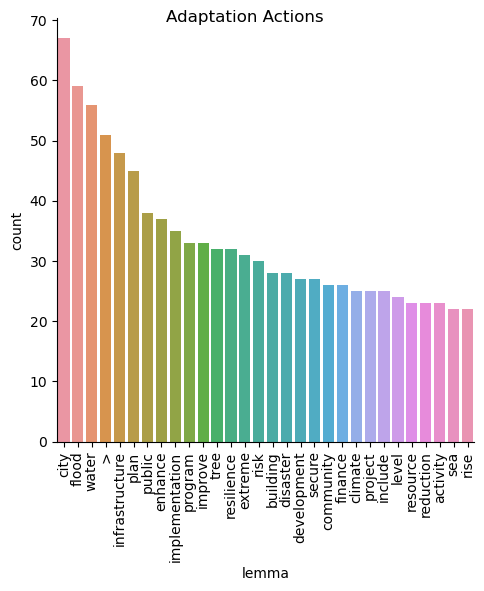

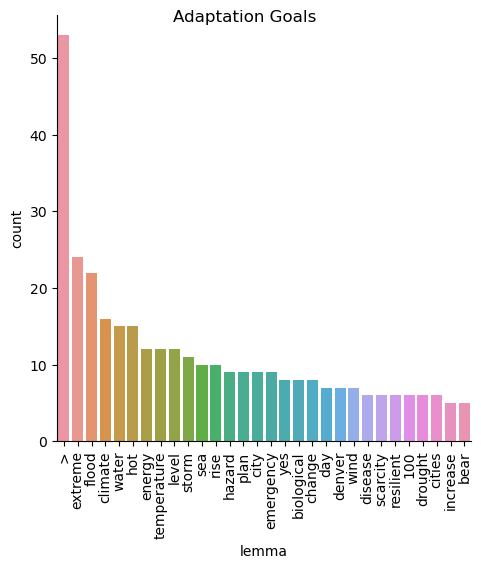

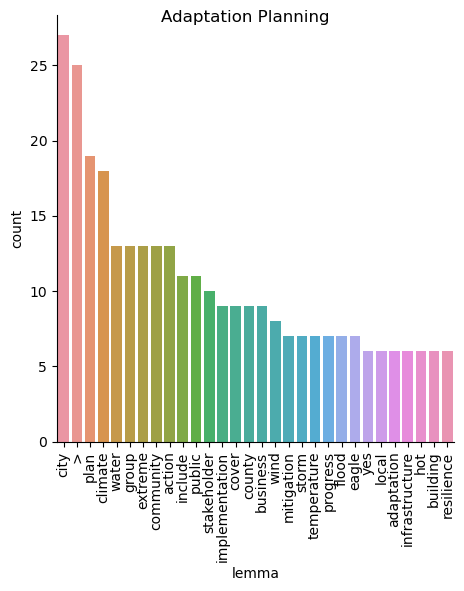

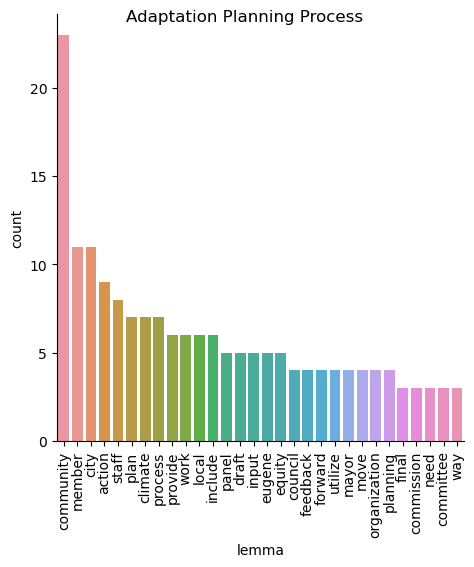

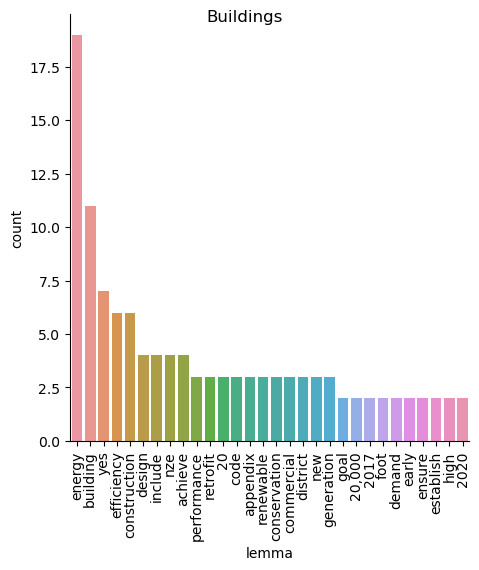

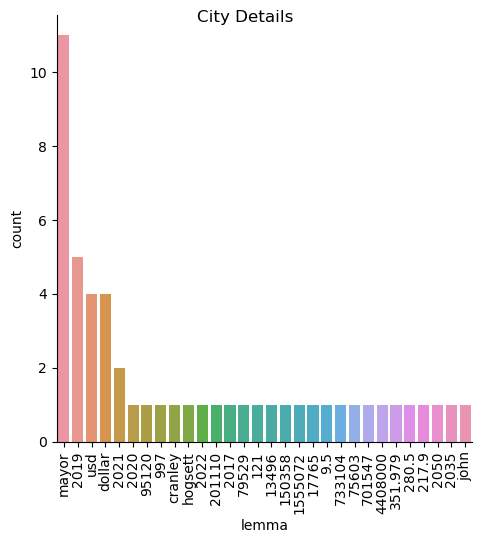

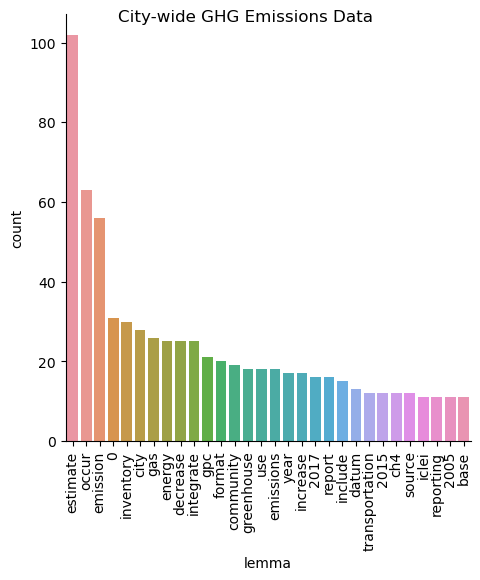

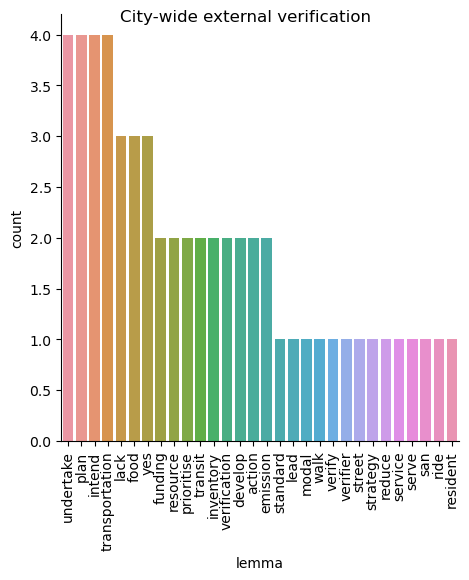

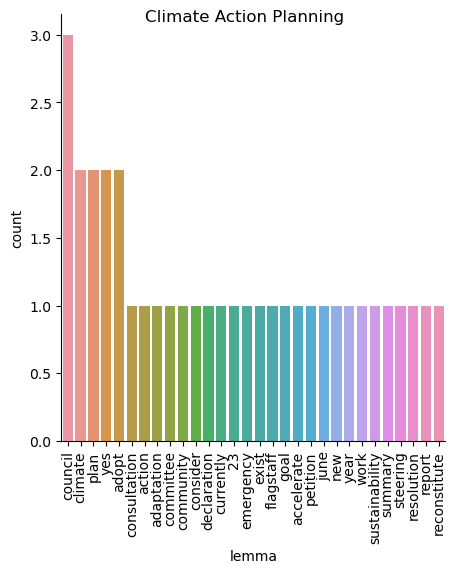

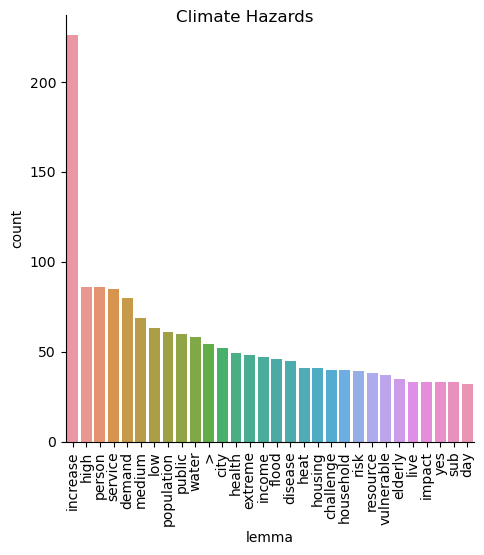

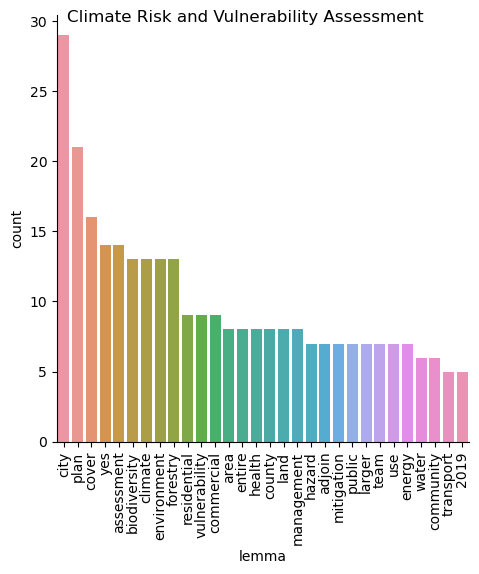

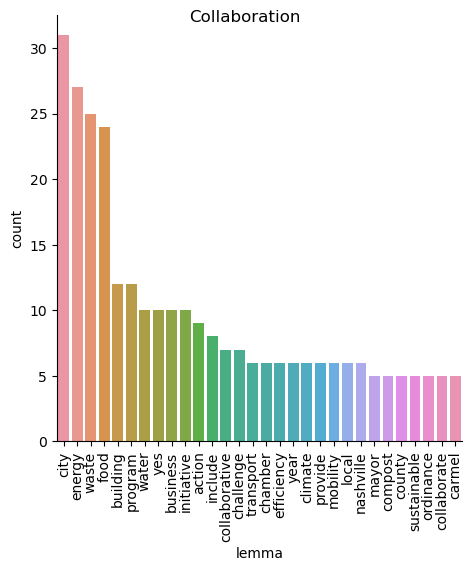

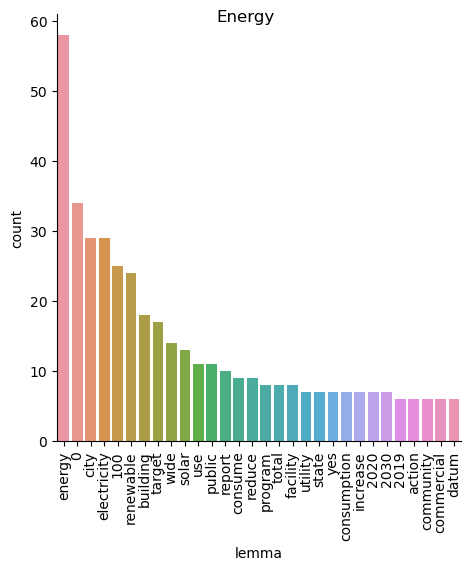

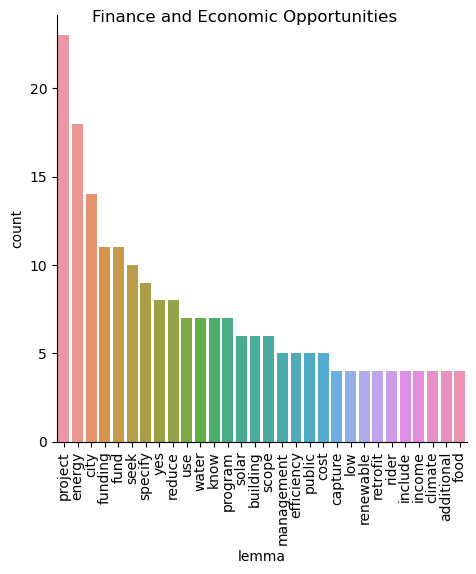

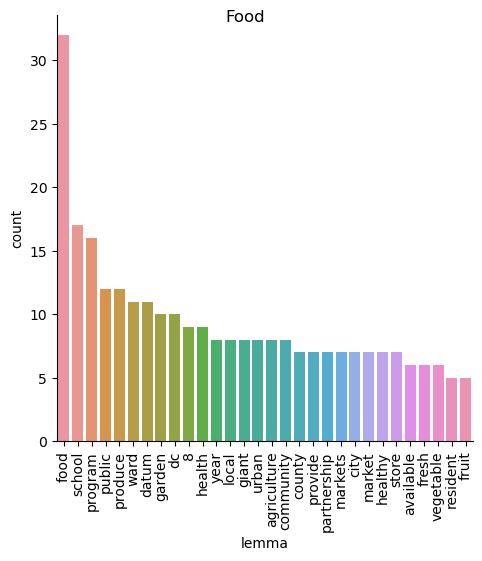

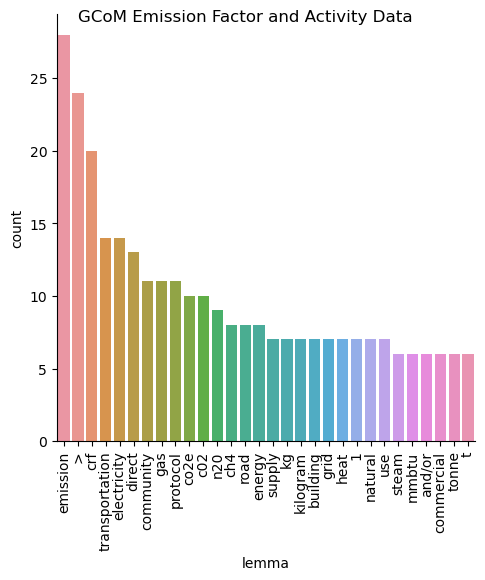

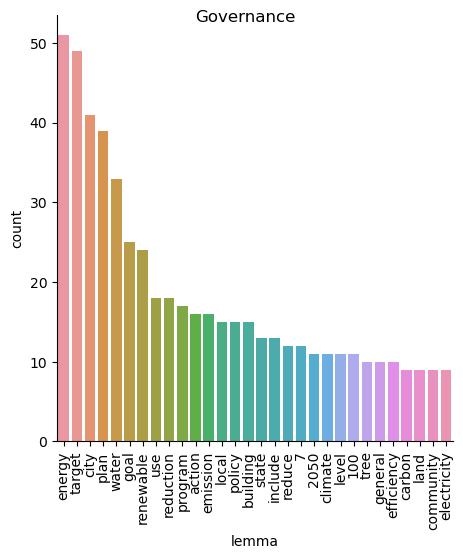

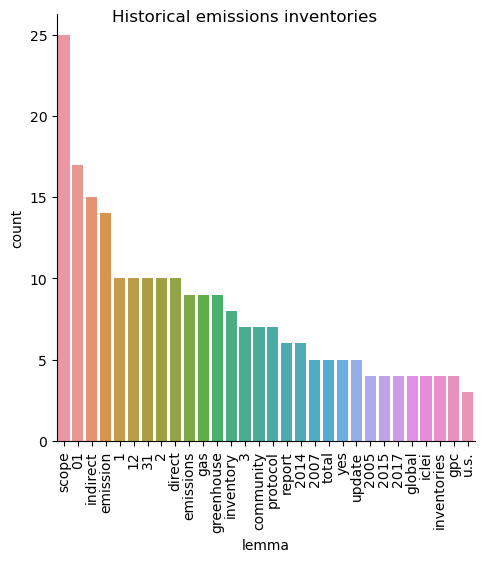

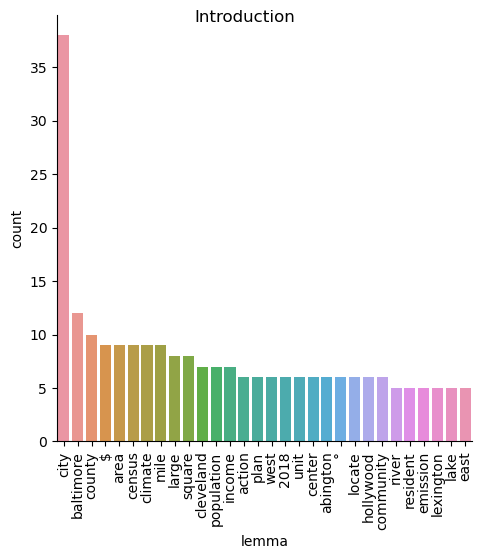

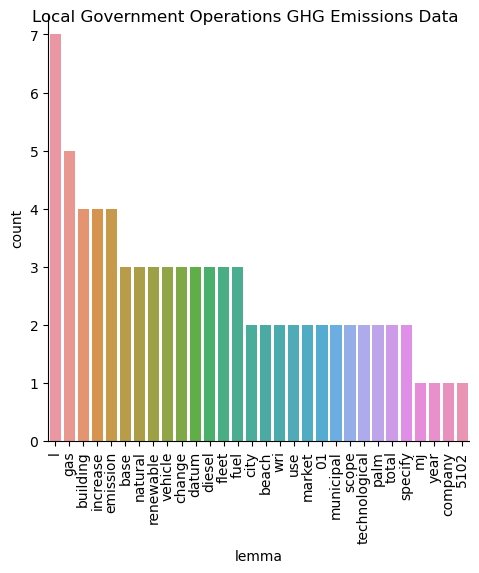

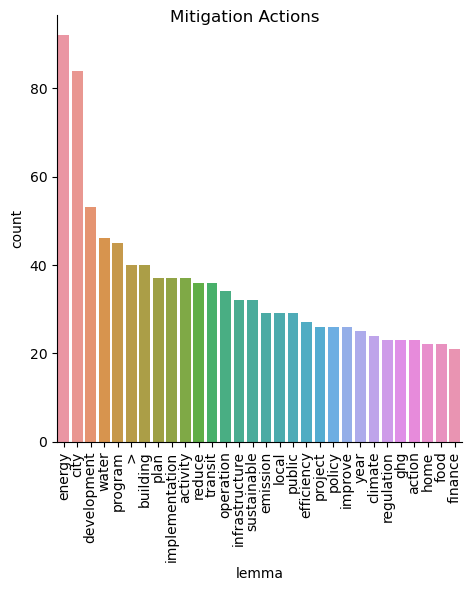

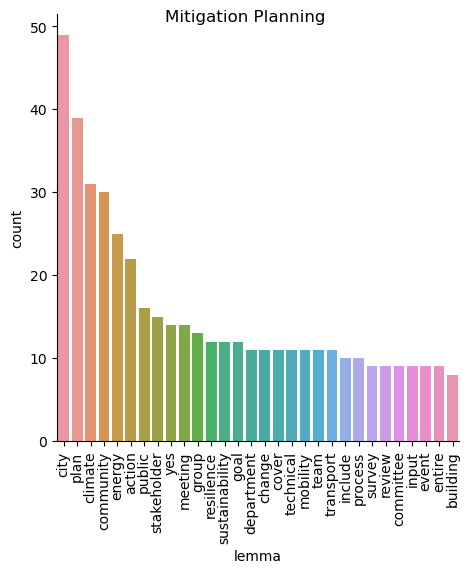

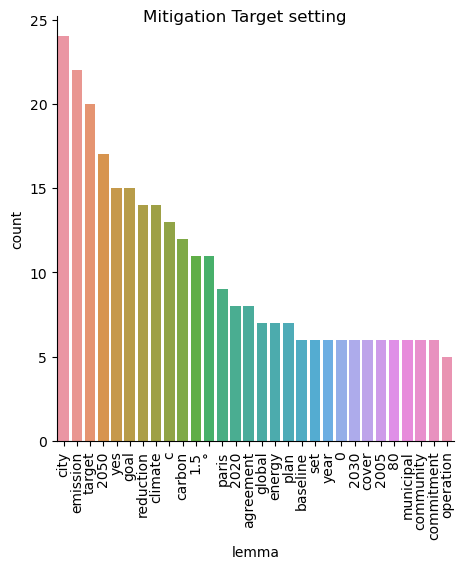

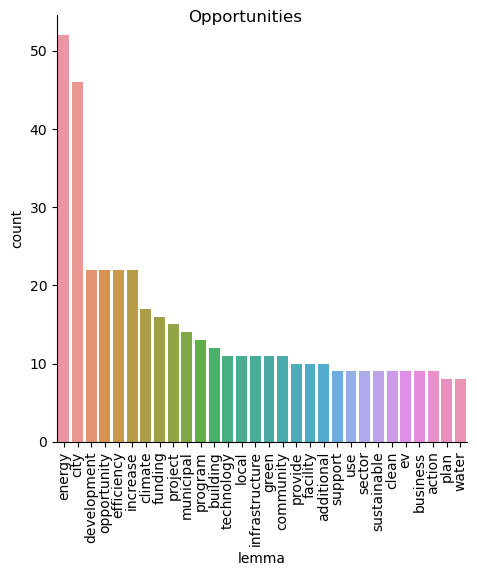

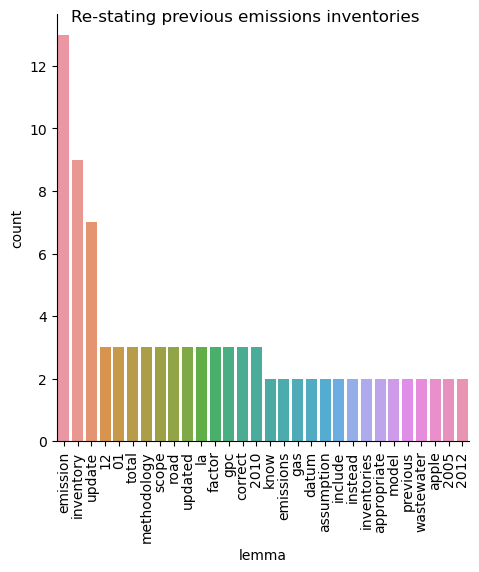

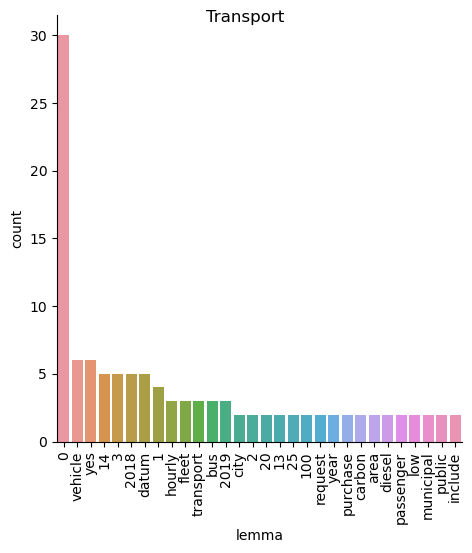

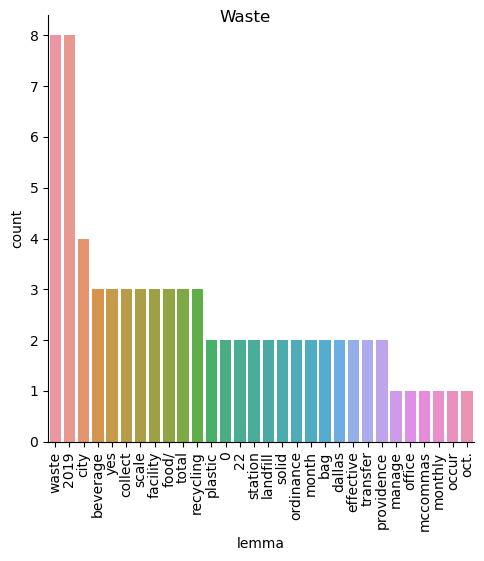

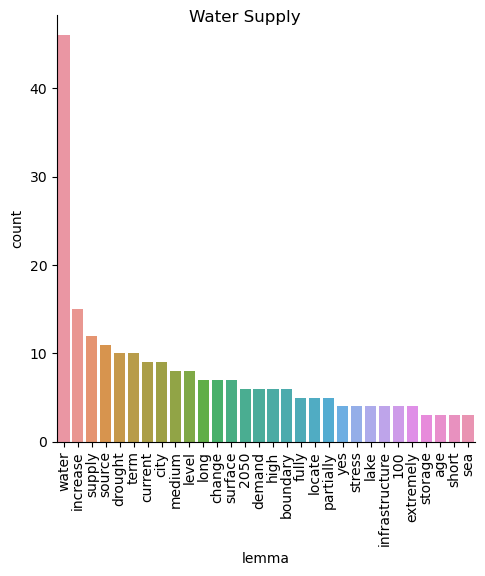

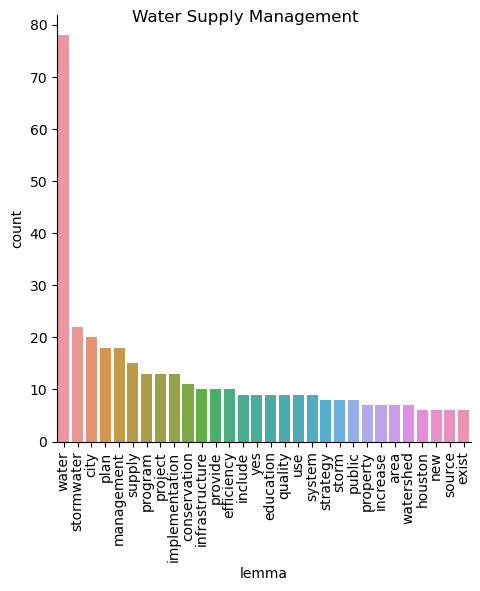

In [43]:
#Counts of top 30 lemma by subsector- graphs (just show 30 )

#for each section, create a plot
for sect in lemma_counts_grouped_w_rank_30.Sect.unique():
    
    #bar plot
    p=sns.catplot(kind='bar',\
                  data=lemma_counts_grouped_w_rank.loc[lemma_counts_grouped_w_rank.Sect==sect].sort_values("count",ascending=False).head(30),
                  x='lemma',
                  y='count')
    p.fig.suptitle(sect)
    p.set_xticklabels(rotation=90)
plt.show()

### We now have most common words per sector

In [48]:
#lets compress the data frame. for each sector, create a list of the lemmas
lemma_counts_grouped_w_rank_30_list = lemma_counts_grouped_w_rank_30.groupby('Sect')['lemma'].apply(list)

#turn it into a DF
lemma_counts_grouped_w_rank_30_list=pd.DataFrame(lemma_counts_grouped_w_rank_30_list).reset_index()
lemma_counts_grouped_w_rank_30_list.columns=['Sect','Common_Words']
lemma_counts_grouped_w_rank_30_list.head(10)

,Sect,Common_Words
0,Adaptation Actions,"[city, flood, water, >, infrastructure, plan, ..."
1,Adaptation Goals,"[>, extreme, flood, climate, water, hot, energ..."
2,Adaptation Planning,"[city, >, plan, climate, water, group, extreme..."
3,Adaptation Planning Process,"[community, city, member, action, staff, plan,..."
4,Buildings,"[energy, building, yes, efficiency, constructi..."
5,City Details,"[mayor, 2019, usd, dollar, 2021, mei, schaaf, ..."
6,City-wide GHG Emissions Data,"[estimate, occur, emission, 0, inventory, city..."
7,City-wide external verification,"[undertake, transportation, plan, intend, lack..."
8,Climate Action Planning,"[council, adopt, climate, plan, yes, 2020, oct..."
9,Climate Hazards,"[increase, person, high, service, demand, medi..."


### Lets find the proportion of words per doc_id that are in the list

In [49]:
#create dataframe of the two tables to include common_words to the list
merged_df = pd.merge(data_sect_id_pos_lemma,lemma_counts_grouped_w_rank_30_list,on='Sect')
merged_df

,Sect,doc_id,pos,lemma,Common_Words
0,Adaptation Actions,1,ADJ,informed,"[city, flood, water, >, infrastructure, plan, ..."
1,Adaptation Actions,1,NOUN,access,"[city, flood, water, >, infrastructure, plan, ..."
2,Adaptation Actions,1,NOUN,datum,"[city, flood, water, >, infrastructure, plan, ..."
3,Adaptation Actions,1,NOUN,decision,"[city, flood, water, >, infrastructure, plan, ..."
4,Adaptation Actions,1,NOUN,making,"[city, flood, water, >, infrastructure, plan, ..."
...,...,...,...,...,...
33662,Water Supply Management,4998,PROPN,anchorage,"[water, stormwater, city, plan, management, su..."
33663,Water Supply Management,4998,PROPN,water,"[water, stormwater, city, plan, management, su..."
33664,Water Supply Management,4998,PROPN,wastewater,"[water, stormwater, city, plan, management, su..."
33665,Water Supply Management,4998,VERB,search,"[water, stormwater, city, plan, management, su..."


In [51]:
#If lemma is in common_words, return true, else false
merged_df['In']=merged_df.apply(lambda row: row['lemma'] in row['Common_Words'],axis=1)
merged_df.head()

,Sect,doc_id,pos,lemma,Common_Words,In
0,Adaptation Actions,1,ADJ,informed,"[city, flood, water, >, infrastructure, plan, ...",True
1,Adaptation Actions,1,NOUN,access,"[city, flood, water, >, infrastructure, plan, ...",True
2,Adaptation Actions,1,NOUN,datum,"[city, flood, water, >, infrastructure, plan, ...",True
3,Adaptation Actions,1,NOUN,decision,"[city, flood, water, >, infrastructure, plan, ...",True
4,Adaptation Actions,1,NOUN,making,"[city, flood, water, >, infrastructure, plan, ...",True


In [52]:
#create a temp table that adds up the "In" column and dividides by total number of "In" rows per dic_id
temp_merge = merged_df.groupby(['Sect','doc_id'],as_index=False).agg(Words_In_List = ('In','sum'),Total_Words=('In','count'))
temp_merge['Word_Proportion']= temp_merge['Words_In_List']/ temp_merge['Total_Words']
final_merge=temp_merge[['Sect','doc_id','Word_Proportion']]
final_merge.head()

,Sect,doc_id,Word_Proportion
0,Adaptation Actions,1,1.000000
1,Adaptation Actions,3,0.000000
2,Adaptation Actions,24,1.000000
3,Adaptation Actions,34,1.000000
4,Adaptation Actions,44,0.333333


In [53]:
#create a pivot table
df = pd.pivot_table(final_merge, values= 'Word_Proportion',index=['doc_id'],columns=['Sect']).fillna(0)
df

Sect,Adaptation Actions,Adaptation Goals,Adaptation Planning,Adaptation Planning Process,Buildings,City Details,City-wide GHG Emissions Data,City-wide external verification,Climate Action Planning,Climate Hazards,...,Local Government Operations GHG Emissions Data,Mitigation Actions,Mitigation Planning,Mitigation Target setting,Opportunities,Re-stating previous emissions inventories,Transport,Waste,Water Supply,Water Supply Management
doc_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4996,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


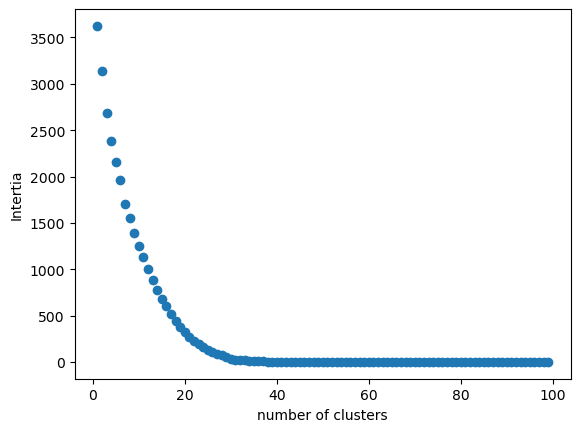

In [60]:
#create a KMeans model
from sklearn.cluster import KMeans
import numpy as np
x_cols = np.array(df)

inertia = []

Ks=range(1,100)

for k in Ks:
    model = KMeans(n_clusters = k)
    model.fit(x_cols)
    inertia.append(model.inertia_)

plt.scatter(Ks,inertia)
plt.xlabel("number of clusters")
plt.ylabel("Intertia")
plt.show()

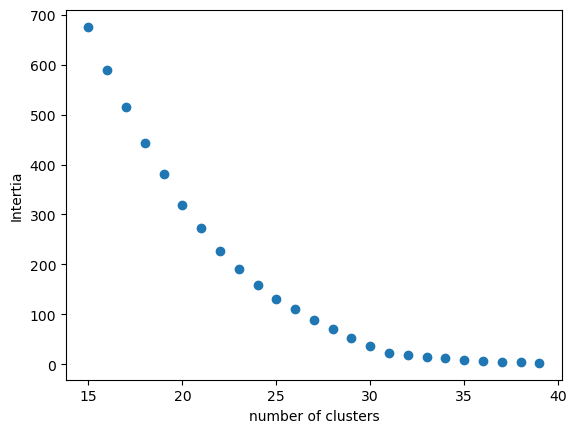

In [61]:
#Lets zoom in between 15 and 40 

x_cols = np.array(df)

inertia = []

Ks=range(15,40)

for k in Ks:
    model = KMeans(n_clusters = k)
    model.fit(x_cols)
    inertia.append(model.inertia_)

plt.scatter(Ks,inertia)
plt.xlabel("number of clusters")
plt.ylabel("Intertia")
plt.show()

Inertia seems to reach a linear trajectory around 30 clusters

In [62]:
#create a df of cluster ID
model = KMeans(n_clusters = 5, random_state = 10)
model.fit(x_cols)
labels = model.predict(x_cols)
labels.shape

doc_id = df.index

cluster_df = pd.DataFrame({'doc_id':doc_id, 'Cluster ID':labels})
cluster_df

,doc_id,Cluster ID
0,0,3
1,1,3
2,2,0
3,3,3
4,4,3
...,...,...
4882,4995,3
4883,4996,3
4884,4997,0
4885,4998,3


In [63]:
#Use PCA to reduce dimensions
from sklearn.decomposition import PCA
model = PCA(n_components = 2,random_state = 10)
components = model.fit_transform(x_cols)
pca_df = pd.DataFrame(components, columns = ['x','y'])
Final_PCA_DF = pd.concat([cluster_df,pca_df],axis=1)
Final_PCA_DF

,doc_id,Cluster ID,x,y
0,0,3,-0.054835,-0.079009
1,1,3,-0.131665,-0.270629
2,2,0,0.836137,0.271467
3,3,3,-0.051006,-0.072267
4,4,3,0.202463,0.025942
...,...,...,...,...
4882,4995,3,-0.054087,-0.077674
4883,4996,3,-0.065132,-0.098351
4884,4997,0,0.836137,0.271467
4885,4998,3,-0.063062,-0.094353


In [64]:
_=sns.scatterplot(data=Final_PCA_DF, x='x',y='y', hue= 'Cluster ID',palette = 'viridis')
_=plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

Result: No trends can be observed. 

### Next Steps: Sum up the questions for each section. Perform Clustering on each account_num

In [66]:
#create a temp table that adds up the "In" column and dividides by total number of "In" rows per dic_id
temp_merge = merged_df.groupby(['Sect','doc_id'],as_index=False).agg(Words_In_List = ('In','sum'),Total_Words=('In','count'))
temp_merge['Word_Proportion']= temp_merge['Words_In_List']/ temp_merge['Total_Words']
final_merge=temp_merge[['Sect','doc_id','Word_Proportion']]
final_merge.head()

,Sect,doc_id,Word_Proportion
0,Adaptation Actions,1,1.000000
1,Adaptation Actions,3,0.000000
2,Adaptation Actions,24,1.000000
3,Adaptation Actions,34,1.000000
4,Adaptation Actions,44,0.333333


In [68]:
#join to expand doc_id into account_num and question_ID
df_merge_by_sect = pd.merge(final_merge,us_data_sample[['index','Account_Num','Question_ID']],\
         left_on='doc_id',right_on='index')\
[['Account_Num','Question_ID','Sect','Word_Proportion']]

#average the word_proportion for each sector/Account_Num 
df_merge_by_sect.groupby(['Account_Num','Sect'],as_index=False)['Word_Proportion'].mean()

,Account_Num,Sect,Word_Proportion
0,1184,Adaptation Actions,0.726389
1,1184,Adaptation Goals,1.000000
2,1184,Buildings,1.000000
3,1184,City-wide GHG Emissions Data,1.000000
4,1184,City-wide external verification,1.000000
...,...,...,...
1386,841964,Climate Hazards,0.733504
1387,841964,Collaboration,1.000000
1388,841964,Energy,1.000000
1389,841964,Mitigation Actions,0.833333


In [69]:
#Pivot Table
df = pd.pivot_table(df_merge_by_sect, values= 'Word_Proportion',index=['Account_Num'],columns=['Sect']).fillna(0)
df

Sect,Adaptation Actions,Adaptation Goals,Adaptation Planning,Adaptation Planning Process,Buildings,City Details,City-wide GHG Emissions Data,City-wide external verification,Climate Action Planning,Climate Hazards,...,Local Government Operations GHG Emissions Data,Mitigation Actions,Mitigation Planning,Mitigation Target setting,Opportunities,Re-stating previous emissions inventories,Transport,Waste,Water Supply,Water Supply Management
Account_Num,,,,,,,,,,,,,,,,,,,,,
1184,0.726389,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.445562,...,0.0,1.000000,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3203,0.833333,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.687500,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3417,0.396825,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.527778,...,1.0,0.559244,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
10495,0.695520,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.808333,...,0.0,0.750000,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
10894,0.509524,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.570248,...,0.0,0.086207,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74508,1.000000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.583333,...,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
74531,0.750000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.392102,...,0.0,0.789394,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
74594,0.687500,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.473846,...,1.0,0.416667,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


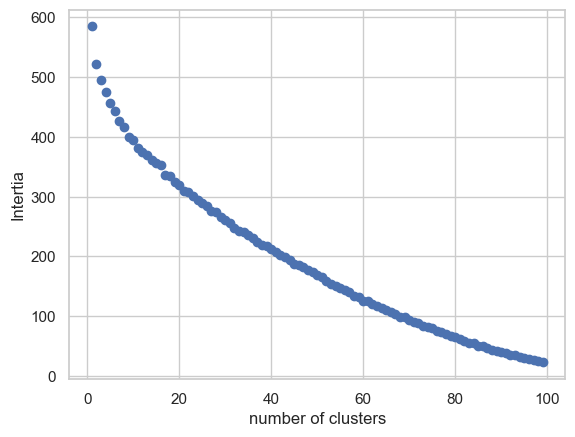

In [1232]:
#Elbow plot
x_cols = np.array(df)
inertia = []

Ks=range(1,100)

for k in Ks:
    model = KMeans(n_clusters = k)
    model.fit(x_cols)
    inertia.append(model.inertia_)

plt.scatter(Ks,inertia)
plt.xlabel("number of clusters")
plt.ylabel("Intertia")
plt.show()

Inertia seems to reach a linear trajectory around 30 clusters

In [ ]:
#Build Models
model = KMeans(n_clusters = 15, random_state = 10)
model.fit(x_cols)
labels = model.predict(x_cols)
labels.shape

Account_Num = df.index

cluster_df = pd.DataFrame({'Account_Num':Account_Num, 'Cluster ID':labels})
cluster_df

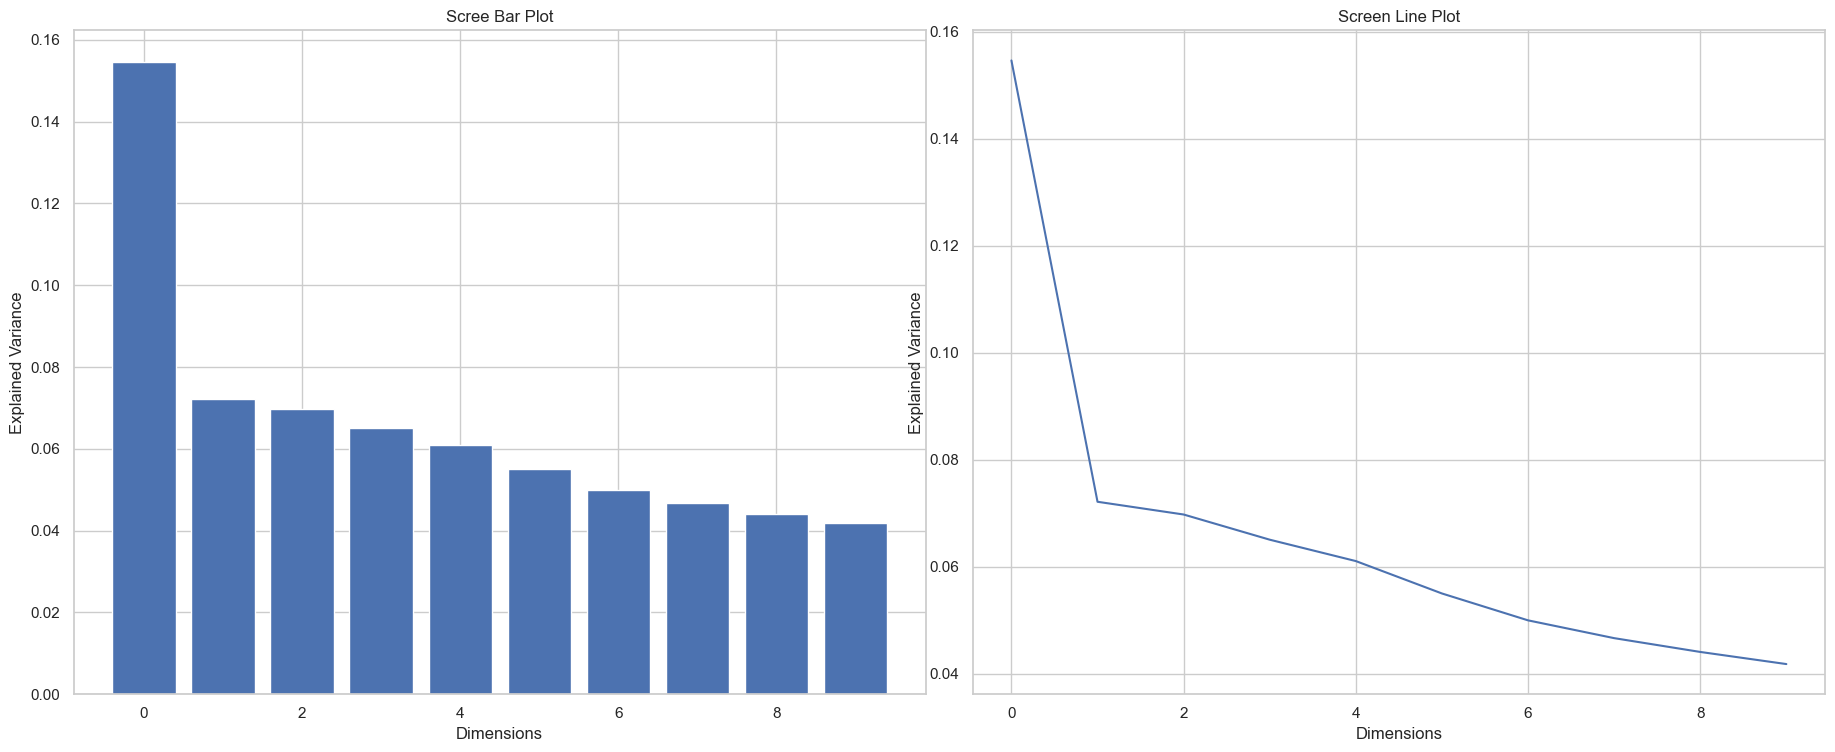

In [1234]:
#Scree Bar plot/Line plots
import sklearn.decomposition
model = sklearn.decomposition.PCA()
model.fit(x_cols)

evr = model.explained_variance_ratio_[:10]
features = range(model.n_components_)

_=fig,ax = plt.subplots(1,2)
_=fig.set_size_inches(18, 7)
_=fig.tight_layout(pad=0.1)

_=ax[0].bar(range(10),evr)
_=ax[0].set_title("Scree Bar Plot")
_=ax[0].set_xlabel('Dimensions')
_=ax[0].set_ylabel('Explained Variance')

_=ax[1].plot(range(10),evr)
_=ax[1].set_title("Screen Line Plot")
_=ax[1].set_xlabel("Dimensions")
_=ax[1].set_ylabel("Explained Variance")

In [1235]:
#PCA our features
from sklearn.decomposition import PCA
model = PCA(n_components = 2,random_state = 10)
components = model.fit_transform(x_cols)
pca_df = pd.DataFrame(components, columns = ['x','y'])
Final_PCA_DF = pd.concat([cluster_df,pca_df],axis=1)
Final_PCA_DF

,Account_Num,Cluster ID,x,y
0,1184,5,-0.904297,-1.056872
1,3203,8,-0.914188,-0.399678
2,3417,3,-0.668474,-0.369925
3,10495,9,0.652933,-0.629460
4,10894,5,-1.187126,-1.213771
...,...,...,...,...
111,74508,1,0.070776,-0.764936
112,74531,1,1.133409,-0.091678
113,74594,9,-0.013595,-0.490406
114,832838,2,2.068317,0.054227


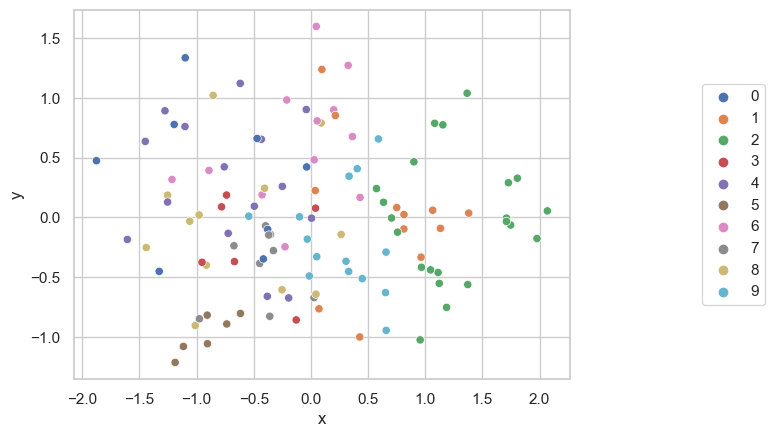

In [1238]:
_=sns.scatterplot(data=Final_PCA_DF, x='x', y='y',hue= 'Cluster ID',palette = 'deep')
_=plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))

Once again; hard to find any sort of clusters here. 

##### 